![header](images/header.png)

# Main run
<!-- [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ec-jrc/lisflood-usecases/mekong_usecase?urlpath=%2Fdoc%2Ftree%2FLF_mekong_usecase%2Fdocs%2Fnotebooks%2F) -->

<br>
<br>
<br>

Once we have done the initialization run and we have estimated the initial conditions in the warmup run, we are in a position to perform our target simulation. We want to simulate the 30 years period between 01-01-1990 and 31-12-2019  in order to estimate the climatology of the hydrological processes in the Nam Ngum River Basin. Remember that in [LISFLOOD time convention](https://ec-jrc.github.io/lisflood-code/2_ESSENTIAL_time-management/) these dates correspond to 02-01-1990 and 01-01-2020, respectively.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from lisflood_read_plot import plot_mapstacks, plot_reservoir, read_tss

path_model = Path('../LF_mekong_usecase')
path_run = path_model / 'results' / 'run'

## 1 Settings file

We will introduce a few changes in the settings file ([`settings_run.xml`](../LF_mekong_usecase/settings_run.xml)) compared with the file used in the warmup:


```xml
<lfoptions>
    
    [...]
    
    # option to compute indicators
    <setoption choice="1" name="indicator"/>
    
    # report time series
    <setoption choice="1" name="repDischargeTs"/>
    <setoption choice="1" name="repsimulateReservoirs"/>
    
    # report maps
    <setoption choice="1" name="repStateMaps"/>
    <setoption choice="0" name="repEndMaps"/>
    <setoption choice="1" name="repDischargeMaps"/>
    <setoption choice="1" name="repTotalAbs"/>
    <setoption choice="1" name="repWIndex"/>
    
    [...]
    
</lfoptions>
    
<lfuser>
    
    [...]
    
    # reporting points
    <textvar name="Gauges" value="102.32 18.62 102.82 19.30 102.67 18.12"/>
    
    # time-related variables
    <textvar name="CalendarDayStart" value="02/01/1979 00:00"/>
    <textvar name="StepStart" value="02/01/1990 00:00"/>
    <textvar name="StepEnd" value="01/01/2000 00:00"/>
    <textvar name="timestepInit" value="01/01/1990 00:00"/>
    <textvar name="ReportSteps" value="1..99999"/>
    
    # paths
    <textvar name="PathInit" value="$(PathRoot)/results/initial"/>
    <textvar name="PathWarm" value="$(PathRoot)/results/warmup"/>
    <textvar name="PathOut" value="$(PathRoot)/results/run"/>
    
    # initial conditions
    <textvar name="OFDirectInitValue" value="$(PathWarm)/ofdir_end.nc"/>
    <textvar name="OFOtherInitValue" value="$(PathWarm)/ofoth_end.nc"/>
    [...]
    <textvar name="LZInitValue" value="$(PathWarm)/lz"/>
    <textvar name="ReservoirInitialFillValue" value="$(PathWarm)/rsfil_end.nc"/>
    
    [...]

</lfuser>

<lfbinding>
    
    [...]
    
    # initialization
    <textvar name="LZAvInflowMap" value="$(PathInit)/lzavin"/>
    <textvar name="AvgDis" value="$(PathInit)/avgdis"/>
    
    [...]
    
</lfbinding>
```

In the `<lfoptions>` section, we activate/deactivate the time series and maps to be reported. We chose to report time series of discharge (`repDischargeTs`) and reservoirs (`repsimulateReservoirs`); these options will save text files (in TSS format) with the respective time series. Regarding maps, in this case we're not interested in the end state maps, therefore `repEndMaps` is deactivated. We're only interested in the map stacks of state variables, therefore we activated `RepStateMaps`. However, this option will not create the discharge and water abstraction map stacks; for that we need to activate the variables `repDischargeMaps` and `RepTotalAbs`. Finally, to generate the water exploitation index maps, we need to activate both `indicator` and `repWIndex`.

In the `<lfuser>` section, we need to set several features. First, the points in the river network for which time series output will be generated; we define three points using their longitude and latitude separated by spaces (there are other posibilities to set the reporting points). We set the simulation period, i.e., the start and end dates (`StepStart` and `StepEnd`), the timestep from which initial conditions may be read (`timestepInit`) and the timesteps that will be included in the output map stacks (`ReportSteps`). Later, the paths for the initial conditions and outputs are set. Finaly, the location of the initial condition maps must be specified. Special remark on the lower groundwater zone initial value (`LZInitValue`), for which we generated a map stack during the [warmup run](2_warmup.ipynb), instead of an end map; that's the reason why the directory where the map is located is different.

> **Note**. Pay special attention to the 5 nines in the variable `ReportSteps` (`1..99999`), which are necessary since the simulation exceeds the 10,000 timesteps

In the `<lfbinding>` element, same as in the warmup run, we must define the two maps that we generated in the [initialization run](1_initialization.ipynb).

## 2 Run the simulation

This step is similar to the two previous runs, but pointing at the specific settings file ([`settings_run.xml`](../LF_mekong_usecase/settings_run.xml)).

```shell
conda activate your_lisflood_environment
cd <path_where_you_saved_the_repository>/lisflood-usecases
lisflood LF_mekong_usecase/settings_run.xml
```

## 3 Outputs

In this section we will see some of the outputs that the simulation has generated, which include map stacks and time series.

In [2]:
settings_file = path_model / 'settings_run.xml'

### 3.1 Map stacks

#### 3.1.1 Soil layers

First, we will analyse the water stored in the soil layers. We'll load the data and then plot it. The maps show the average over time, whereas the lineplot shows the time series obtained by computing the spatial average for each timestep. In the first case we get an insight into the spatial variability, whereas in the second case into the temporal variability.

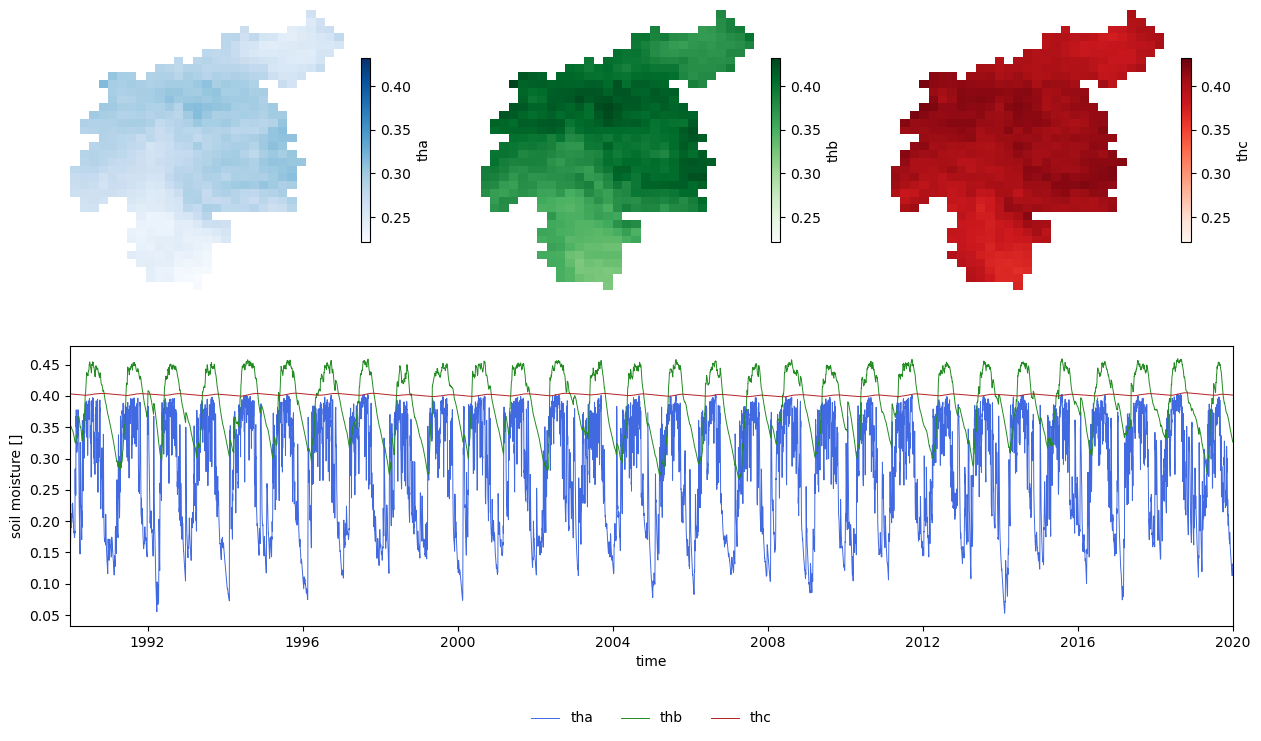

In [3]:
# load and plot some map stacks
soil_storages = {}
for var in ['tha', 'thb', 'thc']:
    da = xr.open_dataarray(path_run / f'{var}.nc')
    da.close()
    soil_storages[var] = da

# calculate minimum and maximum values of soil moisture among all the map stacks
vmin = np.min([da.mean('time').min() for var, da in soil_storages.items()])
vmax = np.max([da.mean('time').max() for var, da in soil_storages.items()])
plot_mapstacks(soil_storages, vmin=vmin, vmax=vmax, ylabel='soil moisture')

***Figure 1**. Evolution of soil moisture in the three soil layers throughout the main run.*

From the previous plots we can extract the following thoughts:

* The superficial soil ($th_a$) shows a much higher temporal variability, since this layer is the most affected by precipitation and evapotranspiration.
* The upper soil layer ($th_b$) has a seasonal variation. The "wet" season shows a lag with respect to the "wet" season in the superficial soil.
* The lower soil layer ($th_c$) has also a seasonal variation, but at a much lower scale than the other two soil layers, reason why it's bearly noticeable in this plot.

#### 3.1.2 Groundwater zones

Let's do a similar analysis on the two groundwater zones.

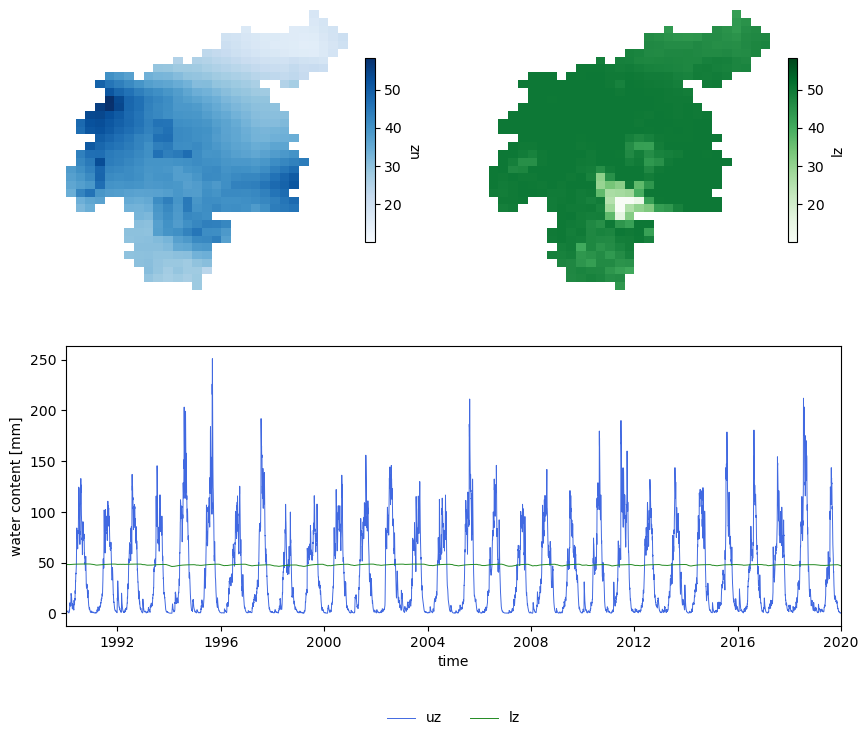

In [4]:
# load and plot some map stacks
gw = {}
for var in ['uz', 'lz']:
    da = xr.open_dataarray(path_run / f'{var}.nc')
    da.close()
    gw[var] = da

# calculate minimum and maximum values among all the map stacks
vmin = np.min([da.mean('time').min() for var, da in gw.items()])
vmax = np.max([da.mean('time').max() for var, da in gw.items()])
plot_mapstacks(gw, vmin=vmin, vmax=vmax, ylabel='water content')

***Figure 2**. Evolution of the two groundwater storages trhoughout the main run.*

From this plot we can infer that, in this case, both zones show seasonality, but the order of magnitude of this seasonal variation differs. Whereas the annual pattern in the upper zone ($\text{uz}$) is clearly visible in the lineplot, that of the lower zone ($\text{lz}$) is unnoticeable.

#### 3.1.3 Discharge

In the case of discharge, apart from the average map over time, we will plot the discharge time series for the outlet.

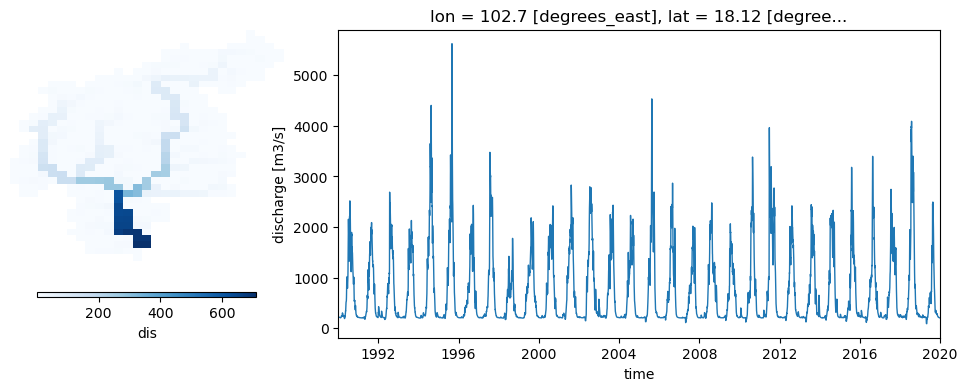

In [5]:
# read map stack of daily discharge
dis = xr.open_dataarray(path_run / 'dis.nc')

# extract time series at the outlet
outlet = dis.mean('time').argmax(['lat', 'lon'])
dis_outlet = dis.isel(outlet)

# configure plot
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, figure=fig)

# map of daily mean
ax1 = fig.add_subplot(gs[0,0])
ax1.axis('off')
dis.mean('time').plot(
    ax=ax1, 
    cmap='Blues',
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40, "pad": 0.1}
)

# daily timeseries of areal mean
ax2 = fig.add_subplot(gs[0,1:])
outlet = dis.mean('time').argmax(['lat', 'lon'])
dis_outlet.plot(lw=1, ax=ax2)
# configure timeseries plot
ax2.set(
    xlim=(dis.time.data[0], dis.time.data[-1]),
    ylabel=f'discharge [{dis.units}]'
);

***Figure 3**. Average river discharge and time series of river discharge at the catchment outlet.*

The same discharge time series at the catchment outlet can be generated directly from the model simulation. For that, the option `repDischargeTs` in the settings file must be active, and the variable `Gauges` must include the coordinates of the outlet. 

#### 3.1.4 Reservoir and rice irrigation

In this section we will analyse the map stacks generated by the reservoir and the rice irrigation options. First, we will load the map stacks and later we will plot the data.

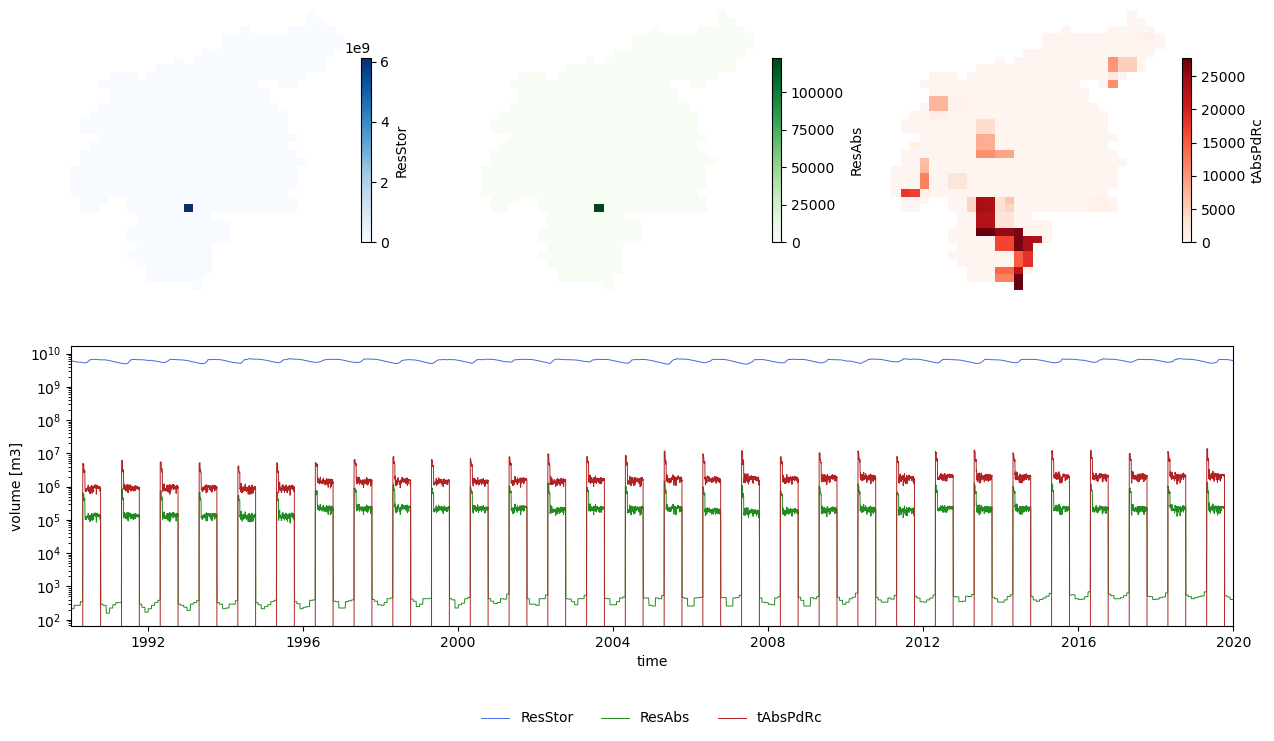

In [6]:
# load map stacks
water_use = {}
for var in ['ResStor', 'ResAbs', 'tAbsPdRc']:
    da = xr.open_dataarray(path_run / f'{var}.nc')
    da.close()
    water_use[var] = da

plot_mapstacks(water_use, agg='sum', ylabel='volume', yscale='log')

***Figure 4**. Evolution of the reservoir volumen over the main run.*

The two maps on the top left show, respectively, mean reservoir storage and mean reservoir abstraction. Since there is only one reservoir in the catchment, only one cell has a value larger than zero. We can use this map to find the location of the reservoir and extract from the map stack the time series of reservoir storage for that cell (blue line in the lineplot). A similar procedure is carried out for the map stack of reservoir abstraction to produce the green line in the lineplot. 

Finally, the paddy rice irrigation map (plot on the top right) shows the areas in the catchment where rice is produced and the average amount of water required. The map stack of rice abstraction is used to create a total rice irrigation demand (red line in the lineplot). Pay attention to the scale of the $y$ axis in the lineplot; it is in logarithmic scale in order to show the variability of abstraction and rice irrigation despite their much lower order of magnitude compared with the reservoir storage.

As shown in these plots, from the map stacks we can extract time series. As we will see later, activating the option `repsimulateReservoir` in the settings file generates time series (TSS files) of the reservoir simulation. However, in the case of the reservoir storage, the TSS file represents relative filling, instead of stored volume.

#### 3.1.5 Water exploitation indexes

As we activated the options `indicator` and `repWIndex`, a series of water index maps were generated:
    
* WDI: water dependency index

$$WDI = \frac{\text{local Water Demand Not Met By Local Water}}{\text{total Water Demand}}$$

* WSI: water security index

$$WSI = \frac{\text{upstream Inflow Actually Used}}{\text{upstream Inflow Available}}$$

* WTI: water sustainability index

$$WTI = 1 - \frac{\text{surface Water Deficit}}{\text{total Water Demand}}$$
    
All these maps have monthly resolution, even though the simulation has daily timesteps.

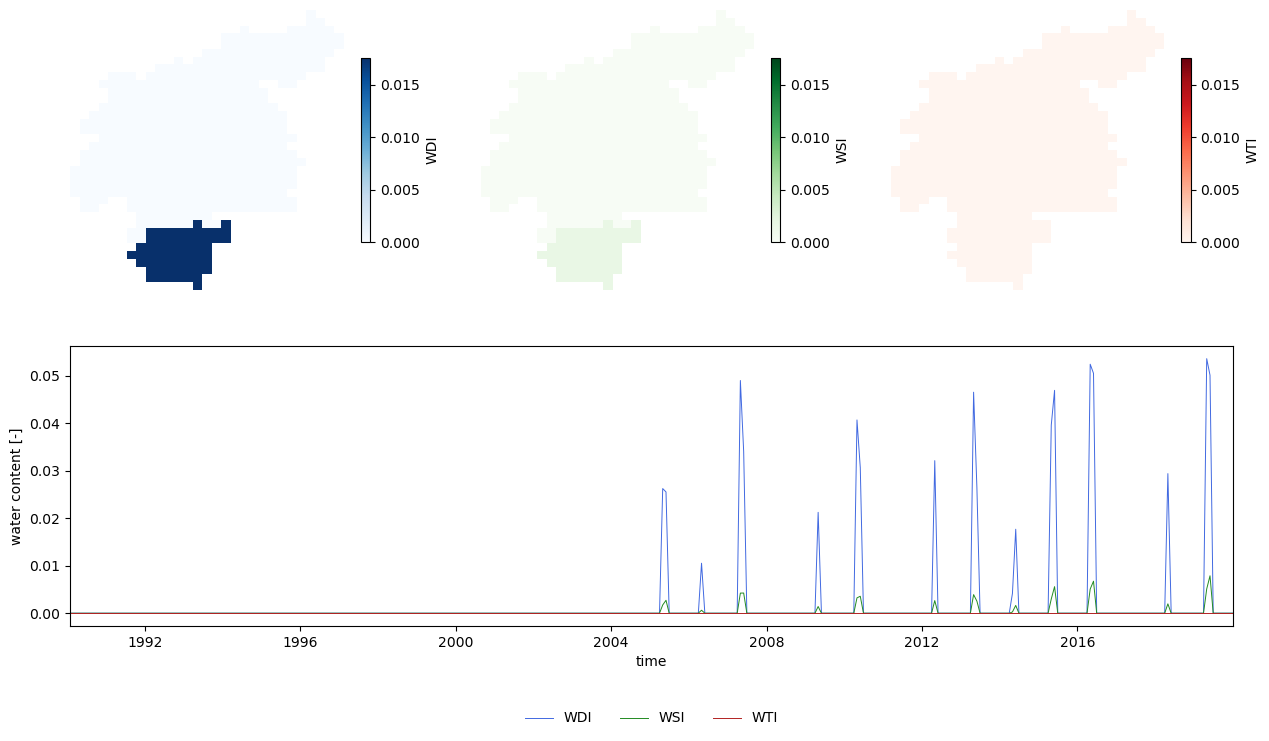

In [7]:
# load and plot some map stacks
wi = {}
for var in ['WDI', 'WSI', 'WTI']:
    da = xr.open_dataarray(path_run / f'{var}.nc')
    da.close()
    wi[var] = da

# calculate minimum and maximum values among all the map stacks
vmin = np.min([da.mean('time').min() for var, da in wi.items()])
vmax = np.max([da.mean('time').max() for var, da in wi.items()])
plot_mapstacks(wi, vmin=vmin, vmax=vmax, ylabel='water content')

***Figure 5**. Water indexes. Maps are averages over the whole period; time series are averages over the whole catchment.*

The maps reproduce the water regions; with the southern region having a slightly higher water demand stress. In the time series we observe that from 2005 onwards there are recurrent periods in which some of the local demands are not met by local water (peaks in WDI).

### 3.2 Time series
#### 3.2.1 Discharge

As mentioned before, discharge time series can be produced directly from the model. The option `repDischargeTs` in the settings file must be active, and the variable `Gauges` must define the points of interest (in our case using the coordinates, but there are other ways to set it). We defined three points in which the model will generate time series. Let's check the results:

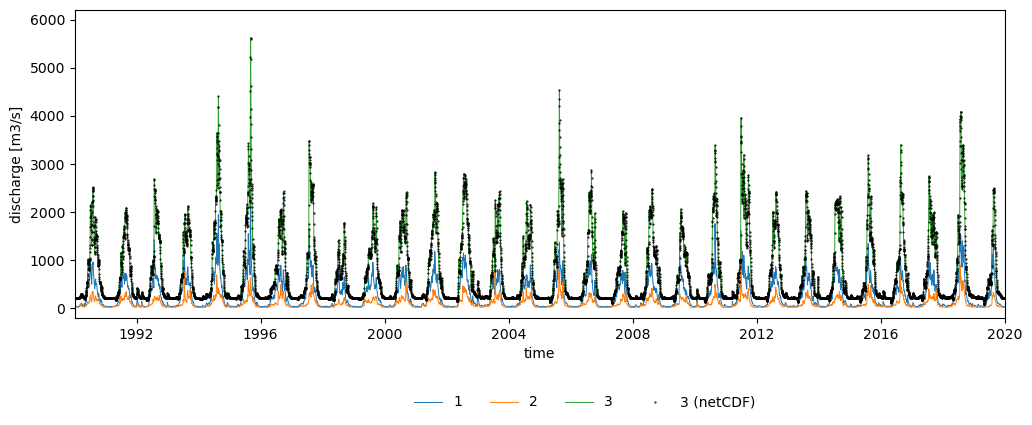

In [8]:
# import time series
disWin = read_tss(path_run / 'disWin.tss', xml=settings_file)

# plot time series
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(disWin, lw=.7, label=disWin.columns)
dis_outlet.plot(
    linestyle='', 
    marker='o', 
    markersize=0.5, 
    color='k', 
    ax=ax, 
    label='3 (netCDF)'
)
ax.set(
    xlim=(disWin.index[0], disWin.index[-1]),
    ylim=(-200, 6200),
    ylabel='discharge [m3/s]',
    title=''
)
fig.legend(loc=8, ncol=4, bbox_to_anchor=[0.5, -0.15, .1, .1], frameon=False);

***Figure 6**. Discharge time series at the three points of interest.*

The `disWin.tss` file includes the discharge time series for the three points we defined. Each point is assigned an identifier; in our case, the catchment outlet corresponds to point 3. For the sake of comparison, the plot includes as points the discharge time series at the outlet extracted from the discharge map stack (`dis.nc`) in section Discharge; the values of the TSS file are equal to those of the netCDF.

#### 3.2.2 Reservoirs

We have activated the option `repsimulateReservoirs` in the settings file, so the simulation has created three TSS files representing the inflow (`qresin.tss`), outflow (`qresout.tss`) and relative filling (`resfill.tss`) of the reservoirs. In our case, since there's only one reservoir in the catchment, only one time series is included in each of these TSS files. Let's load these time series and plot the reservoir simulation.

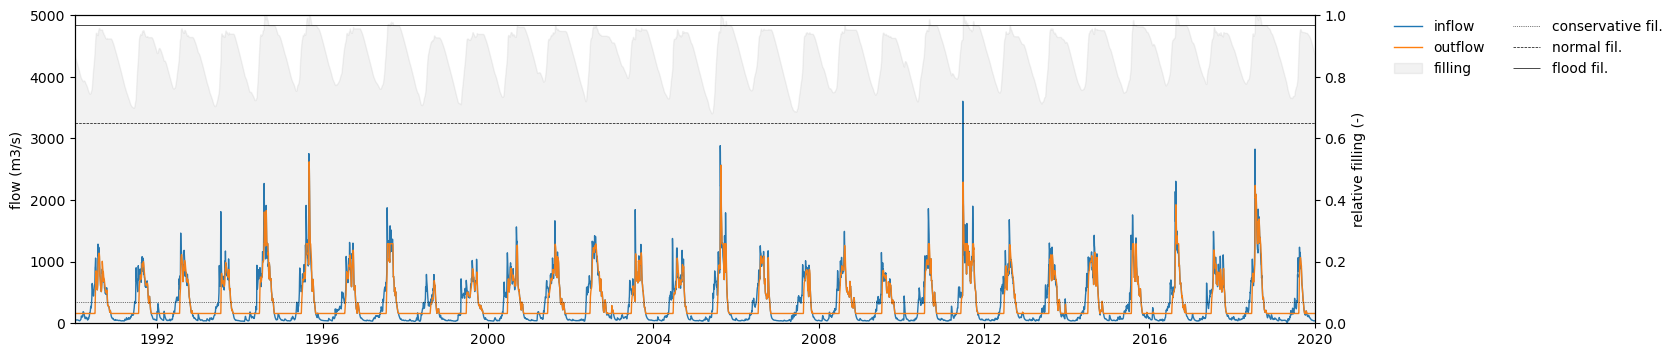

In [9]:
# load reservoir time series
timeseries = {
    'inflow': 'qresin',
    'outflow': 'qresout',
    'filling': 'resfill'
}
res_ts = {}
for var, file in timeseries.items():
    ts = read_tss(path_run / f'{file}.tss', xml=settings_file, squeeze=True)
    res_ts[var] = ts
res_ts = pd.DataFrame.from_dict(res_ts)

# load reservoir relative filling limits
limits = {
    'conservative': 'c',
    'normal': 'n',
    'flood': 'f'
}
res_lim = {}
for var, file in limits.items():
    res_lim[var] = pd.read_csv(
        path_model / 'tables' / 'reservoirs' / f'r{file}lim.txt', 
        sep='\s+', 
        header=None, 
        index_col=0
    ).iloc[0,0]

# plot reservoir simulation
plot_reservoir(
    res_ts, 
    clim=res_lim['conservative'], 
    nlim=res_lim['normal'],
    flim=res_lim['flood']
)

***Figure 7**. Reservoir inflow, outflow and relative filling.*

Conclusions from this plot:

* The reservoir storage is kept between the normal and flood limits throughout most of the simulation period. In 1994, 1995 and 1997 there are three exceptions in which the storage exceeded the flood limit.